In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from Scratch import metadata_loader
import numpy as np
from tqdm import tqdm

DEVICE = "ibm_sherbrooke"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 50

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")


# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[md['notebook_name']=='Sherbrooke_RepCodes_jobs']

# md = md[0:1]
print("shape:", md.shape)
md[:2]


state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5030,2024-03-23 14:05:45.787000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzd7adk5z70008j0810,"[Subset 52, 50 rounds, 0 log, xbasis=False]",1.0,1507.0,NaN,JobStatus.DONE,2024-03-23 15:09:21.245239+01:00,RepetitionCodeCircuit,52,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."
5029,2024-03-23 14:05:37.855000+01:00,Sherbrooke_RepCodes_jobs,ibm_sherbrooke,cqzd78ds9z7g008dpaa0,"[Subset 52, 50 rounds, 0 log, xbasis=False]",1.0,1507.0,NaN,JobStatus.DONE,2024-03-23 15:08:51.313737+01:00,RepetitionCodeCircuit,52,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.007733045348037, 'min_ga..."


In [3]:
from result_saver import SaverProvider

provider = SaverProvider()

In [4]:
md_loc = 0

job_id = md.iloc[md_loc]["job_id"]
job = provider.retrieve_job(job_id) 

execution_date = job.result().date
memory = job.result().get_memory()

print(f"Execution date: {execution_date}")

Execution date: 2024-03-23 15:09:21.245239+01:00


In [5]:
assert md_loc == 0
for id in range(1, 5):
    job = provider.retrieve_job(md.iloc[id]["job_id"])
    memory = np.vstack([memory, job.result().get_memory()])

In [6]:
from soft_info import inv_qubit_mapping, get_repcode_IQ_map

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

# Needed decoding objects

#### KDE

In [7]:
import numpy as np

_RESETS = False
SOFT_MUL = 0.5
T = md.iloc[md_loc]["rounds"]
d = md.iloc[md_loc]["distance"]

shots = md.iloc[md_loc]["shots"]

rel_error = 1

# KDE BANDWIDTHS
lin = [0.1, 0.7, 30]
num_points = 51
bandwidths = np.linspace(lin[0], lin[1], lin[2])
bandwidths = [0.6]

In [8]:
from soft_info import get_repcode_IQ_map
from soft_info import inv_qubit_mapping
from Scratch import load_calibration_memory
import cpp_soft_info
from datetime import datetime

all_memories, gmm_dict, msmt_err_dict = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                other_date=execution_date, post_process=True,
                                                                double_msmt=False)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

all_memories_PS, gmm_dict_PS, msmt_err_dict_PS = load_calibration_memory(provider, tobecalib_backend=DEVICE, 
                                                                other_date=execution_date, post_process=True,
                                                                double_msmt=True)

kde_dict_PS = cpp_soft_info.get_KDEs(all_memories_PS, bandwidths, relError=rel_error, absError=-1, num_points=num_points)

Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 14:09:53.452291+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2024-03-23 14:10:23.035893+00:00.


In [9]:
# Get the layout of the last job (same as previous)
layout_des = job.deserialize_layout(job.initial_layouts()[0]) # only 1 layout
link_qubits = list(layout_des['link_qubit'].values())
code_qubits = list(layout_des['code_qubit'].values())

# Get the pSoft and countMat matrices
big_layout = link_qubits + code_qubits
inverted_q_map = inv_qubit_mapping(get_repcode_IQ_map(big_layout, synd_rounds=T))

# EstimConvertor

In [10]:
pSoft, countMat, estim0Mat, estim1Mat = cpp_soft_info.iqConvertorEstim(memory, inverted_q_map, kde_dict, rel_error)

In [11]:
qubit = 69
cols = inverted_q_map[qubit]

pSoft_sub = pSoft[:, cols]
countMat_sub = countMat[:, cols]
estim0Mat_sub = estim0Mat[:, cols]
estim1Mat_sub = estim1Mat[:, cols]

memory_sub = memory[:, cols]

In [12]:
# post select for estim threshold 

threshold = 1e-2
mask = (estim0Mat_sub > threshold) | (estim1Mat_sub > threshold)   

data = memory_sub[mask]
p_soft_data = pSoft_sub[mask]
print(f"Data shape: {data.shape}")
print(f"ratio: {data.shape[0]/(memory_sub.shape[0]*memory_sub.shape[1])}")

Data shape: (342055,)
ratio: 0.9079097544790975


In [13]:
print(data[0])

(-40091762+66143739j)


09:24:45 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 115


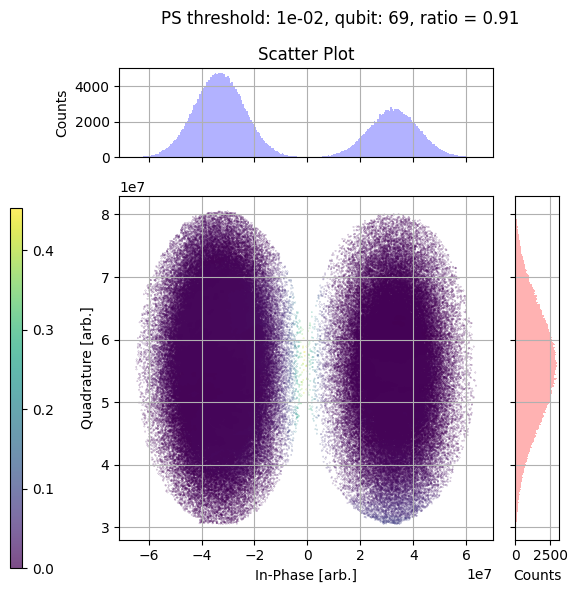

In [14]:
from soft_info import plot_IQ_data_pSoft_cmap

plot_IQ_data_pSoft_cmap(data, p_soft_data, figsize=(6,6), 
                        title=f"PS threshold: {threshold:.0e}, qubit: {qubit}, ratio = {data.shape[0]/(memory_sub.shape[0]*memory_sub.shape[1]):.2f}")

# Post select shots

In [23]:

threshold_estim = 1e-3
threshold_ratio_leaked = 0.005

mask_below_threshold = (estim0Mat < threshold_estim) & (estim1Mat < threshold_estim)

# Calculate the proportion of 'True' values in each row
proportion_below_threshold = np.mean(mask_below_threshold, axis=1)

# Create a mask to retain rows where less than 10% of the data meets the mask_below_threshold criteria
mask = proportion_below_threshold < threshold_ratio_leaked

# Apply the mask
data_filtered = memory[mask, :]
p_soft_filtered = pSoft[mask, :]
count_filtered = countMat[mask, :]

# Printing results
print(f"estim threshold: {threshold_estim:.0e}, ratio threshold: {threshold_ratio_leaked:.0e}")
print(f"Filtered data shape: {data_filtered.shape}")
print(f"Filtered pSoft shape: {p_soft_filtered.shape}")
print(f"Filtered countMat shape: {count_filtered.shape}")
print(f"Initial data shape: {memory.shape}")
print(f"Ratio of retained data: {data_filtered.shape[0] / memory.shape[0]}")


estim threshold: 1e-03, ratio threshold: 5e-03
Filtered data shape: (3491, 2602)
Filtered pSoft shape: (3491, 2602)
Filtered countMat shape: (3491, 2602)
Initial data shape: (7535, 2602)
Ratio of retained data: 0.4633045786330458


09:28:20 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 115


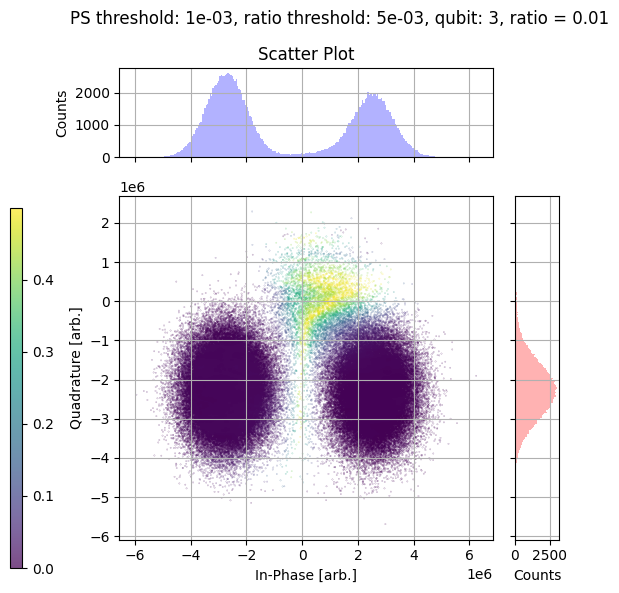

09:28:21 Warning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.. IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/plotter.py, LINE: 115


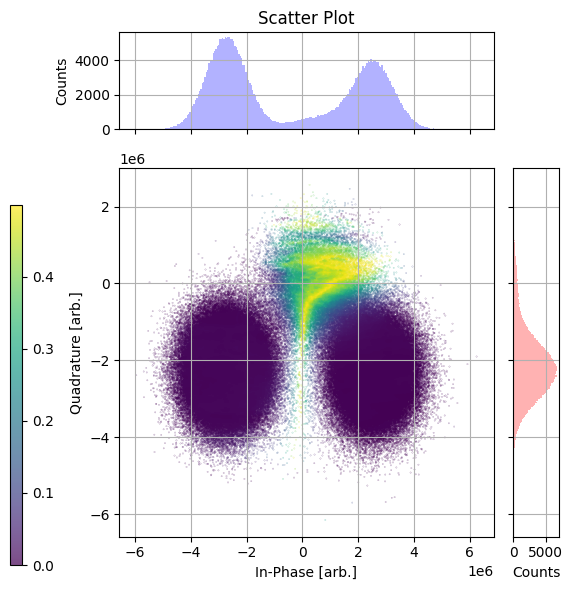

In [24]:
qubit = 3
cols = inverted_q_map[qubit]

memory_sub_pre = memory[:, cols]


pSoft_sub = p_soft_filtered[:, cols]
countMat_sub = count_filtered[:, cols]
memory_sub = data_filtered[:, cols]

plot_IQ_data_pSoft_cmap(memory_sub, pSoft_sub, figsize=(6,6),
                        title=f"PS threshold: {threshold_estim:.0e}, ratio threshold: {threshold_ratio_leaked:.0e}, qubit: {qubit}, ratio = {data_filtered.shape[0]/(memory_sub_pre.shape[0]*memory_sub_pre.shape[1]):.2f}")

plot_IQ_data_pSoft_cmap(memory_sub_pre, pSoft[:, cols], figsize=(6,6))

In [23]:
# PS: any entry cannot be leaked 

threshold = 1e-3

mask_below_threshold = (estim0Mat < threshold) & (estim1Mat < threshold)
mask_any_below_threshold = np.any(mask_below_threshold, axis=1)
mask = ~mask_any_below_threshold

data_filtered = memory[mask, :]
p_soft_filtered = pSoft[mask, :]
count_filtered = countMat[mask, :]

print(f"Filtered data shape: {data_filtered.shape}")
print(f"Filtered pSoft shape: {p_soft_filtered.shape}")
print(f"Filtered countMat shape: {count_filtered.shape}")
print(f"Ratio of retained data: {data_filtered.shape[0] / memory.shape[0]}")

Filtered data shape: (8, 2602)
Filtered pSoft shape: (8, 2602)
Filtered countMat shape: (8, 2602)
Ratio of retained data: 0.00106171201061712


In [17]:
import numpy as np

# Seed for reproducibility
np.random.seed(42)

# Number of data points and dimensions
num_data = 4
num_features = 4

# Generate synthetic data
memory_test = np.random.normal(0, 1, (num_data, num_features))
pSoft_test = np.random.random((num_data, num_features))
estim0Mat_test = np.random.random((num_data, num_features))
estim1Mat_test = np.random.random((num_data, num_features))

# Threshold for the estimations
threshold = 0.5

# Create a mask where both estim0 and estim1 are below the threshold
mask_below_threshold = (estim0Mat_test < threshold) & (estim1Mat_test < threshold)

# Now create a mask to identify rows where any entry has both estims below the threshold
mask_any_below_threshold = np.any(mask_below_threshold, axis=1)

# We want rows where NOT any entry has both estim0 and estim1 below the threshold
mask = ~mask_any_below_threshold

# Apply the mask
data_filtered = memory_test[mask, :]
p_soft_filtered = pSoft_test[mask, :]


print(f"pSoft_test: {pSoft_test}")
print(f"estim0Mat_test: {estim0Mat_test}")
print(f"estim1Mat_test: {estim1Mat_test}")

print(f"p_soft_filtered: {p_soft_filtered}")


pSoft_test: [[0.61185289 0.13949386 0.29214465 0.36636184]
 [0.45606998 0.78517596 0.19967378 0.51423444]
 [0.59241457 0.04645041 0.60754485 0.17052412]
 [0.06505159 0.94888554 0.96563203 0.80839735]]
estim0Mat_test: [[0.30461377 0.09767211 0.68423303 0.44015249]
 [0.12203823 0.49517691 0.03438852 0.9093204 ]
 [0.25877998 0.66252228 0.31171108 0.52006802]
 [0.54671028 0.18485446 0.96958463 0.77513282]]
estim1Mat_test: [[0.93949894 0.89482735 0.59789998 0.92187424]
 [0.0884925  0.19598286 0.04522729 0.32533033]
 [0.38867729 0.27134903 0.82873751 0.35675333]
 [0.28093451 0.54269608 0.14092422 0.80219698]]
p_soft_filtered: [[0.61185289 0.13949386 0.29214465 0.36636184]
 [0.06505159 0.94888554 0.96563203 0.80839735]]
